In [1]:
from urllib import request

import tensorflow as tf

from io import StringIO
from collections import Counter
import re
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import nltk
from __future__ import print_function
from keras.layers import Dense, Activation, SimpleRNN, LSTM
from keras.models import Sequential
from nltk.stem import WordNetLemmatizer
import wordcloud as w
import matplotlib.pyplot as plot


2024-11-21 07:40:54.897317: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-21 07:40:54.906666: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732167654.918098    5446 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732167654.921422    5446 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-21 07:40:54.933087: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
shelley_frank = request.urlopen('https://www.gutenberg.org/cache/epub/84/pg84.txt').read()

In [3]:
shelley_frank = shelley_frank.decode('utf-8-sig')
print(shelley_frank[:100])

The Project Gutenberg eBook of Frankenstein; Or, The Modern Prometheus
    
This ebook is for the 


In [4]:
actual_start = 'You will rejoice'
word_index = shelley_frank.find(actual_start)

In [5]:
if word_index != -1:
    shelley_frank = shelley_frank[word_index:]


In [6]:
shelley_frank = re.sub(r'—', ' ', shelley_frank.lower())
shelley_frank = shelley_frank.replace('project gutenberg', '')
shelley_frank = nltk.word_tokenize(shelley_frank)
shelley_frank = ' '.join(shelley_frank)  

# Ensure space after punctuation if it's missing
print(shelley_frank[:100])

you will rejoice to hear that no disaster has accompanied the commencement of an enterprise which yo


In [7]:
shelley_frank = re.sub(r'[^a-zA-Z.,!?; ]', '', shelley_frank)
shelley_frank = re.sub(r'([.,!?;])', r'\1 ', shelley_frank)
shelley_frank = re.sub(r'\s+([.,!?;])', r'\1', shelley_frank)
shelley_frank = re.sub(r'\s+', ' ', shelley_frank) 
print(shelley_frank[:1000])

you will rejoice to hear that no disaster has accompanied the commencement of an enterprise which you have regarded with such evil forebodings. i arrived here yesterday, and my first task is to assure my dear sister of my welfare and increasing confidence in the success of my undertaking. i am already far north of london, and as i walk in the streets of petersburgh, i feel a cold northern breeze play upon my cheeks, which braces my nerves and fills me with delight. do you understand this feeling? this breeze, which has travelled from the regions towards which i am advancing, gives me a foretaste of those icy climes. inspirited by this wind of promise, my daydreams become more fervent and vivid. i try in vain to be persuaded that the pole is the seat of frost and desolation; it ever presents itself to my imagination as the region of beauty and delight. there, margaret, the sun is for ever visible, its broad disk just skirting the horizon and diffusing a perpetual splendour. there for wi

In [8]:
sentences = nltk.sent_tokenize(shelley_frank)
sentence_lengths = [len(nltk.word_tokenize(sentence)) for sentence in sentences]

print(np.mean((sentence_lengths)))

25.459254947613505


In [9]:
separate_chars = sorted(set(shelley_frank.lower()))

In [10]:
print(separate_chars)

[' ', '!', ',', '.', ';', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [11]:
charachter_index = {char: idx for idx, char in enumerate(separate_chars)}
index_characters = np.array(separate_chars)

print(charachter_index)
print(index_characters)

{' ': 0, '!': 1, ',': 2, '.': 3, ';': 4, '?': 5, 'a': 6, 'b': 7, 'c': 8, 'd': 9, 'e': 10, 'f': 11, 'g': 12, 'h': 13, 'i': 14, 'j': 15, 'k': 16, 'l': 17, 'm': 18, 'n': 19, 'o': 20, 'p': 21, 'q': 22, 'r': 23, 's': 24, 't': 25, 'u': 26, 'v': 27, 'w': 28, 'x': 29, 'y': 30, 'z': 31}
[' ' '!' ',' '.' ';' '?' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l'
 'm' 'n' 'o' 'p' 'q' 'r' 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']


In [12]:
# numerically represent the characters
text_as_integers = np.array([charachter_index[c] for c in shelley_frank.lower()])

In [13]:
# create training examples and targets
# Use average sentence length to improve results
seq_length = 27
examples_per_epoch = len(shelley_frank.lower()) // (seq_length + 1)

# create training sequences
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_integers)

sequences = char_dataset.batch(seq_length + 1, drop_remainder=True)

W0000 00:00:1732073965.990807    5174 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [14]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

In [15]:
for input_text, target_text in dataset.take(5):  # Take the first 5 examples
    # 
    input_text_decod = ''.join(index_characters[input_text.numpy()])
    # Decode target_text
    target_text_decod = ''.join(index_characters[target_text.numpy()])
    
    print(f"Input text: {input_text_decod}")
    print(f"Target text: {target_text_decod}")

Input text: you will rejoice to hear th
Target text: ou will rejoice to hear tha
Input text: t no disaster has accompani
Target text:  no disaster has accompanie
Input text: d the commencement of an en
Target text:  the commencement of an ent
Input text: erprise which you have rega
Target text: rprise which you have regar
Input text: ded with such evil forebodi
Target text: ed with such evil forebodin


2024-11-20 05:39:28.083970: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [16]:
# How many samples are run through before paramater shuffle
BATCH_SIZE = 128
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

train_size = int(0.8 * len(dataset)) 
val_size = len(dataset) - train_size

train_dataset = dataset.take(train_size)  # First 80%
val_dataset = dataset.skip(train_size)   # Remaining 20%

In [17]:
vocab_size = len(separate_chars)

# the embedding dimension
hidden_dimension = 256

# number of Layers - too little underfits too much overfits
rnn_units = 256

lstm_units = 256

def build_model(vocab_size, hidden_dimension, rnn_units, batch_size, model_type):
    if model_type == 'lstm':
        model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, hidden_dimension),
        tf.keras.layers.LSTM(lstm_units, return_sequences=True, stateful=True, recurrent_initializer='glorot_uniform'),
        #tf.keras.layers.Dropout(0.2),
        #tf.keras.layers.LSTM(int((lstm_units/4)), return_sequences=True, stateful=True, recurrent_initializer='glorot_uniform'),
            # Overfit prevention with dropout layer
         #   tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(lstm_units, activation='relu'),  # Dense layer
            tf.keras.layers.Dense(vocab_size),
        ])
    if model_type == 'rnn':
        model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, hidden_dimension),
        tf.keras.layers.SimpleRNN(rnn_units, return_sequences=True, stateful=True, recurrent_initializer='glorot_uniform'),
        #tf.keras.layers.Dropout(0.2),
        #tf.keras.layers.SimpleRNN(int((rnn_units/4)), return_sequences=True, stateful=True, recurrent_initializer='glorot_uniform'),
       # tf.keras.layers.SimpleRNN(int((rnn_units)), return_sequences=True, stateful=True, recurrent_initializer='glorot_uniform'),
        # Overfit prevention with dropout layer
        # Overfit prevention with dropout layer
        #tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(rnn_units, activation='relu'), 
        tf.keras.layers.Dense(vocab_size),
        ])
    return model

rnn_train_model = build_model(vocab_size, hidden_dimension, rnn_units, BATCH_SIZE,'rnn')
lstm_train_model = build_model(vocab_size, hidden_dimension, rnn_units, BATCH_SIZE,'lstm')


In [18]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

# Set lstn manual optimizer adam = Adaptive moment optimizer 
# How fast does the model learn is set here. Internal changes changed at this rate
lstm_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
# Set rnn manual optimizer adam = Adaptive moment optimizer 
rnn_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
metrics = ['accuracy']

lstm_train_model.compile(optimizer=lstm_optimizer, loss=loss,metrics=metrics)

rnn_train_model.compile(optimizer=rnn_optimizer, loss=loss, metrics=metrics)

In [20]:
# Checkpoint dir for model configs - Saved if new results are better than previous ones
lstm_checkpoint_dir = './tmp/lstm/ckpt/checkpoint.model.keras'
rnn_checkpoint_dir = './tmp/rnn/ckpt/checkpoint.model.keras'

# LSTM Checpoint callback creation
lstm_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=lstm_checkpoint_dir,
    save_weights_only=False
)

# RNN checkpoint callback creation
rnn_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=rnn_checkpoint_dir,
    save_weights_only=False
)


In [21]:
def plot_out_metrics(his, title):
    history_d = his.history
    acc = history_d['accuracy']
    loss = history_d['loss']
    v_loss = history_d['val_loss']
    v_acc = history_d['val_accuracy']
    
    plot.subplot(1, 2, 1)  # Create a subplot for accuracy
    plot.plot(acc, label='Training accuracy', color='cyan')
    plot.plot(v_acc, label='Validation accuracy', color = 'navy')
    plot.xlabel('Epochs')
    plot.ylabel('Accuracy')
    plot.title(f'{title}: Accuracy')
    plot.grid()
    plot.legend()
    
    plot.subplot(1, 2, 2)  # Create a subplot for accuracy
    plot.plot(loss, label='Training loss', color='orange')
    plot.plot(v_loss, label='Validation loss', color = 'red')
    plot.xlabel('Epochs')
    plot.ylabel('Loss')
    plot.title(f'{title}: Loss')
    plot.grid()
    plot.legend()

Epoch 1/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.2459 - loss: 2.6786 - val_accuracy: 0.3765 - val_loss: 2.0719
Epoch 2/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.3947 - loss: 2.0127 - val_accuracy: 0.4257 - val_loss: 1.8925
Epoch 3/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.4374 - loss: 1.8609 - val_accuracy: 0.4537 - val_loss: 1.8015
Epoch 4/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.4603 - loss: 1.7832 - val_accuracy: 0.4734 - val_loss: 1.7399
Epoch 5/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.4763 - loss: 1.7265 - val_accuracy: 0.4888 - val_loss: 1.6994
Epoch 6/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.4878 - loss: 1.6894 - val_accuracy: 0.4956 - val_loss: 1.6715
Epoch 7/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.4970 - loss: 1.6587 - val_accuracy: 0.4976 - val_loss: 1.6528
Epoch 8/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.5031 - loss: 1.6322 - val_accu

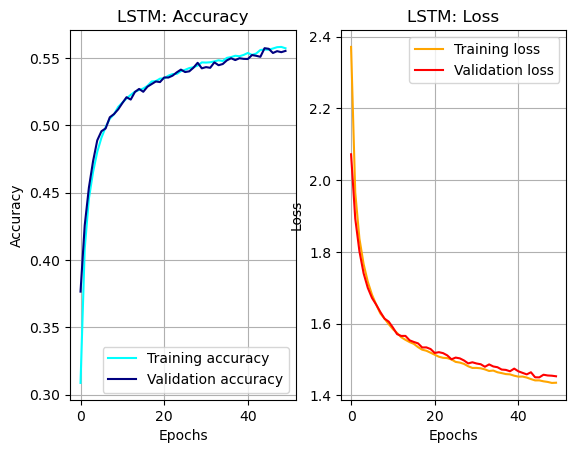

In [39]:
# Train and run the lstm_model
# Set epochs for model training - Epochs allow model to adjust weights. 1 Epoch is full passtrough of network
LSTM_EPOCHS = 50
%time history = lstm_train_model.fit(train_dataset, epochs=LSTM_EPOCHS, callbacks=[lstm_checkpoint_callback], validation_data=val_dataset)
plot_out_metrics(history, 'LSTM')

Epoch 1/40
208/208 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.2756 - loss: 2.5291 - val_accuracy: 0.3989 - val_loss: 2.0016
Epoch 2/40
208/208 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.4097 - loss: 1.9619 - val_accuracy: 0.4395 - val_loss: 1.8683
Epoch 3/40
208/208 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.4444 - loss: 1.8458 - val_accuracy: 0.4602 - val_loss: 1.7924
Epoch 4/40
208/208 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.4624 - loss: 1.7790 - val_accuracy: 0.4730 - val_loss: 1.7426
Epoch 5/40
208/208 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.4771 - loss: 1.7332 - val_accuracy: 0.4846 - val_loss: 1.7100
Epoch 6/40
208/208 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.4855 - loss: 1.7042 - val_accuracy: 0.4905 - val_loss: 1.6897
Epoch 7/40
208/208 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.4908 - loss: 1.6803 - val_accuracy: 0.4917 - val_loss: 1.6674
Epoch 8/40
208/208 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.4974 - loss: 1.6579 - val_accu

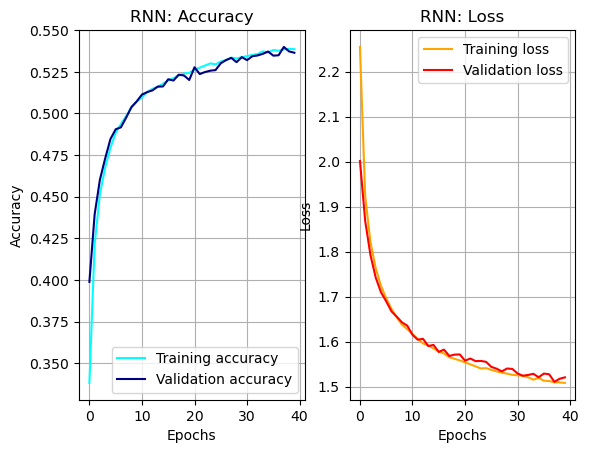

In [26]:
# Train and run the rnn_model
RNN_EPOCHS = 40
%time rnn_history = rnn_train_model.fit(train_dataset, epochs=RNN_EPOCHS, callbacks=[rnn_checkpoint_callback], validation_data=val_dataset)
plot_out_metrics(rnn_history, 'RNN')

In [40]:
%%time
# Build lstm model
lstmmodel = build_model(vocab_size, hidden_dimension, rnn_units, batch_size=1, model_type='lstm')
lstmmodel.build(tf.TensorShape([1,None]))
# Load best model
lstmmodel.load_weights(lstm_checkpoint_dir)
# Show model summary
lstmmodel.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ (1, None, 256)         │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (1, None, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (1, None, 256)         │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (1, None, 32)          │         8,224 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 607,520 (2.32 MB)

 Trainable params: 607,520 (2.32 MB)

 Non-trainable params: 0 (0.00 B)

CPU times: user 61 ms, sys: 8.23 ms, total: 69.2 ms
Wall time: 63.9 ms


In [41]:
%%time
# Build rnn model
rnnmodel = build_model(vocab_size, hidden_dimension, rnn_units, batch_size=1, model_type='rnn')
rnnmodel.build(tf.TensorShape([1,None]))
# Load best model
rnnmodel.load_weights(rnn_checkpoint_dir)
# Show model summary
rnnmodel.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ (1, None, 256)         │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ (1, None, 256)         │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (1, None, 256)         │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (1, None, 32)          │         8,224 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 213,536 (834.12 KB)

 Trainable params: 213,536 (834.12 KB)

 Non-trainable params: 0 (0.00 B)

CPU times: user 47.2 ms, sys: 2.09 ms, total: 49.2 ms
Wall time: 45.4 ms


In [45]:
def generate_text(model, start_string):
    num_generate = 5000
    temperature = 1.0
    input_eval = [charachter_index[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    text_generated = []

    for layer in model.layers:
        if hasattr(layer, 'reset_states'):
            layer.reset_states()
    # Run predictions for the desrired length
    for i in range(num_generate):
        # Run predictions
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions, 0)

        # Apply temperature - in place division
        predictions /= temperature

        # Convert logits to probabilities using softmax - This also 
        predictions = tf.nn.softmax(predictions)

        # Get last element
        predicted_id = tf.random.categorical(tf.math.log(predictions), num_samples=1)[0, 0].numpy()
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(index_characters[predicted_id])

    return (start_string + ''.join(text_generated))


In [134]:
print(shelley_frank[:5000])

you will rejoice to hear that no disaster has accompanied the commencement of an enterprise which you have regarded with such evil forebodings. i arrived here yesterday, and my first task is to assure my dear sister of my welfare and increasing confidence in the success of my undertaking. i am already far north of london, and as i walk in the streets of petersburgh, i feel a cold northern breeze play upon my cheeks, which braces my nerves and fills me with delight. do you understand this feeling? this breeze, which has travelled from the regions towards which i am advancing, gives me a foretaste of those icy climes. inspirited by this wind of promise, my daydreams become more fervent and vivid. i try in vain to be persuaded that the pole is the seat of frost and desolation; it ever presents itself to my imagination as the region of beauty and delight. there, margaret, the sun is for ever visible, its broad disk just skirting the horizon and diffusing a perpetual splendour. there for wi

In [46]:
%time lstm_generated_text = generate_text(lstmmodel, start_string=u"you will rejoice")
print('\nLSTM Generated text\n')
print(lstm_generated_text)

CPU times: user 26.7 s, sys: 226 ms, total: 26.9 s
Wall time: 26.8 s

LSTM Generated text

you will rejoice foundations of your you in construe horeste remained for the new twho shore he share had been me on these semserbut prepare food, if he perceive speckindcame it. he sky. i sachivers of man. the wind pronouncirose ton down posses exhibitary, the agitinsaid you wilon pailing of his terms and i imagined in that pursuit. hive, he may neek every own upo miserable ends sund the seas i thas o hadly re and an agred to changed us discover illumination a fug state of kindness. you country. in its was useful accounted to render its vains journing children orward of a pressed felt force of table of study, slds a coi teak gluenctress of this the stranger made you, gree as on it lay allowed my donation of hatred he looked upon my had w,. my brother read th, the appersed you on the pretty laughter, as you even the books the ensuing, for one lower those ge, r visions. what do you disle weiction.

In [47]:
%time rnn_generated_text = generate_text(rnnmodel, start_string=u"you will rejoice")
print('\nRNN Generated text\n')
print(rnn_generated_text)

CPU times: user 22.2 s, sys: 252 ms, total: 22.4 s
Wall time: 22.4 s

RNN Generated text

you will rejoice after this persuade them, i did thought agitated imagination, was in an copy of malwas several letulate manner so sweet more most about to but my ted you was but i at the parence. it ales of obscuse future i was feear my own senot before cast repulmoosory of the eye so corably quit unsiderable anguished on. oncludy of thour meand welled on this was gone thut. my fferse, if worth did not forld in the room i have been examined with the ceabours it my horizo to which was severod; all was now if, which, for stering; her then tene, and the despingplied her hem, before a feet; anyou glowing expression was object of the favil loved; i have subrt an occuptent tangitary ation was the tocured to d. all many and was unabing y dhabought to the d to ar add alleper of himin of introduce comong the li previnomus me and fortness. ed that conceive intereva summit engag ritted the food. i can to a 

In [48]:
# Average sentence lengths for all generated text, just for comparison
sentences = nltk.sent_tokenize(shelley_frank)
sentence_lengths = [len(nltk.word_tokenize(sentence)) for sentence in sentences]

# Shelley average sentence length
shelley_sent_len = np.mean(sentence_lengths)

#LSTM Sentence length
lstm_sentences = nltk.sent_tokenize(lstm_generated_text)
lstm_sentence_lengths = [len(nltk.word_tokenize(lstm_sentences)) for lstm_sentences in lstm_sentences]
lstm_sent_len = np.mean(lstm_sentence_lengths)

# RNN Sentence length
rnn_sentences = nltk.sent_tokenize(rnn_generated_text)
rnn_sentence_lengths = [len(nltk.word_tokenize(rnn_sentences)) for rnn_sentences in rnn_sentences]
rnn_sent_len = np.mean(rnn_sentence_lengths)

# Sentence lengths correlate very closely to the given sequence length parameter
print(f'Original text sentence length: {shelley_sent_len:.2f}\nLSTM text sentence length: {lstm_sent_len:.2f}\nRNN text sentence length: {rnn_sent_len:.2f}')

Original text sentence length: 25.46
LSTM text sentence length: 18.60
RNN text sentence length: 28.86


In [49]:
def remove_nonalpha(str_input):
    return re.sub(r'[^A-Za-z0-9\s]', '', str_input)

In [50]:
# Remove stopwords and check ngrams
from nltk.corpus import stopwords

frank_5k = shelley_frank[:5000]

# Clean shelley text
stopwords = set(word.lower() for word in stopwords.words('english'))

filtered_shelley = ' '.join(word for word in frank_5k.split() if word.lower() not in stopwords)
filtered_shelley = remove_nonalpha(filtered_shelley)

# Clean lstm text
filtered_lstm = ' '.join(word for word in lstm_generated_text.split() if word.lower() not in stopwords)
filtered_lstm = remove_nonalpha(filtered_lstm)
# Clean rnn text
filtered_rnn = ' '.join(word for word in rnn_generated_text.split() if word.lower() not in stopwords)
filtered_rnn = remove_nonalpha(filtered_rnn)

In [51]:
# Create lemmatizer
lemmatizer = WordNetLemmatizer()

In [52]:
text_tokenized = nltk.word_tokenize(filtered_shelley)

In [54]:
lemmatized_shelley = [lemmatizer.lemmatize(word) for word in text_tokenized]


In [55]:
def get_ngrams(txt, n):
    ngrams = zip(*[txt[i:] for i in range(n)])
    return Counter(["-".join(ngram) for ngram in ngrams])

In [56]:
# Ngrams from original text
reg_unigrams = get_ngrams(lemmatized_shelley, 1)
reg_bigrams = get_ngrams(lemmatized_shelley, 2)
reg_trigrams = get_ngrams(lemmatized_shelley, 3)
reg_fourgrams = get_ngrams(lemmatized_shelley, 4)

In [57]:
# Tokenize lstm
lstm_tokenized = nltk.word_tokenize(filtered_lstm)
lemmatized_lstm_generated = [lemmatizer.lemmatize(word) for word in lstm_tokenized]

# Ngram Creation for LSTM
lstm_unigrams = get_ngrams(lemmatized_lstm_generated, 1)
lstm_bigrams = get_ngrams(lemmatized_lstm_generated, 2)
lstm_trigrams = get_ngrams(lemmatized_lstm_generated, 3)
lstm_fourgrams = get_ngrams(lemmatized_lstm_generated, 4)

In [58]:
# Tokenize and lemmatize rnn generated text
rnn_tokenized = nltk.word_tokenize(filtered_rnn)
lemmatized_rnn_generated = [lemmatizer.lemmatize(word) for word in rnn_tokenized]

# Create Ngrams for rnn
rnn_unigrams = get_ngrams(lemmatized_rnn_generated, 1)
rnn_bigrams = get_ngrams(lemmatized_rnn_generated, 2)
rnn_trigrams = get_ngrams(lemmatized_rnn_generated, 3)
rnn_fourgrams = get_ngrams(lemmatized_rnn_generated, 4)

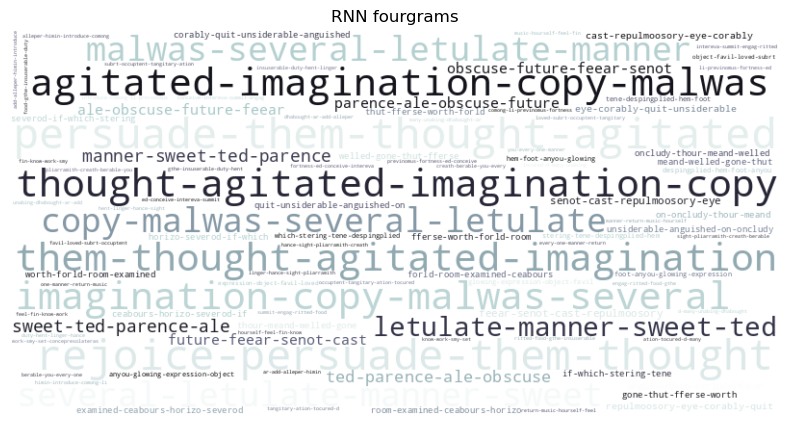

In [71]:
import wordcloud as w
import matplotlib.pyplot as plot
# Rnn wordcloud
rnn_wordcloud_4gram = w.WordCloud(width=800, height=400, background_color='white',
                      max_words=100, colormap='bone_r').generate_from_frequencies(rnn_fourgrams)
plot.figure(figsize=(10, 5))
plot.imshow(rnn_wordcloud_4gram, interpolation='bilinear')
plot.axis('off')  # Hide axes
plot.title('RNN fourgrams')
plot.show()

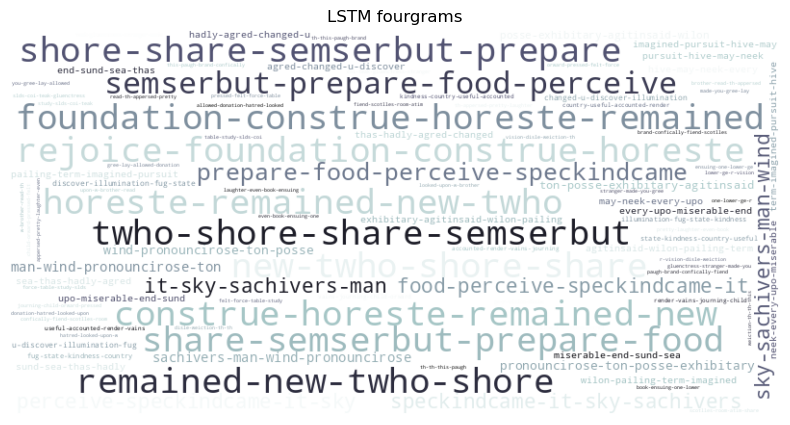

In [70]:
lstm_wordcloud_4gram = w.WordCloud(width=800, height=400, background_color='white',
                      max_words=100, colormap='bone_r').generate_from_frequencies(lstm_fourgrams)
plot.figure(figsize=(10, 5))
plot.imshow(lstm_wordcloud_4gram, interpolation='bilinear')
plot.axis('off')  # Hide axes
plot.title('LSTM fourgrams')
plot.show()

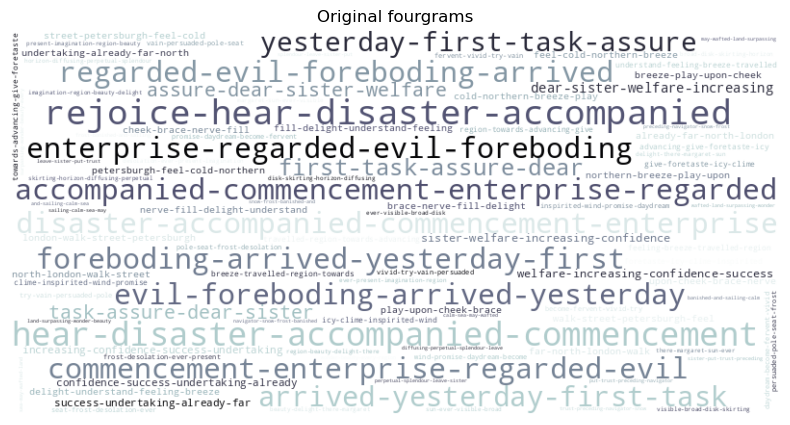

CPU times: user 390 ms, sys: 86.4 ms, total: 477 ms
Wall time: 365 ms


In [61]:
%%time
wit_wordcloud_4gram = w.WordCloud(width=800, height=400, background_color='white',
                      max_words=100, colormap='bone_r').generate_from_frequencies(reg_fourgrams)
plot.figure(figsize=(10, 5))
plot.imshow(wit_wordcloud_4gram, interpolation='bilinear')
plot.title('Original fourgrams')
plot.axis('off')  # Hide axes
plot.show()

In [69]:
from nltk.translate.bleu_score import corpus_bleu
print(len(text_tokenized))
print(len(rnn_tokenized))

def tupled_ngrams(txt, n):
    ngrams = zip(*[txt[i:] for i in range(n)])
    # Return the n-grams as tuples
    return [tuple(ngram) for ngram in ngrams]

#for i in range(1,2):
#    globals()[f"reg_gram_{i}"] = tupled_ngrams(lemmatized_shelley, i)
#    globals()[f"lstm_gram_{i}"] = tupled_ngrams(lemmatized_lstm_generated, i)
#    globals()[f"rnn_gram_{i}"] = tupled_ngrams(lemmatized_rnn_generated, i)

#    globals()[f"rnn_gram_{i}_score"] =

#print(reg_gram_1)
# Fourgrams
fourgrams_ltsm = tupled_ngrams(lemmatized_lstm_generated, 4)
fourgrams_rnn = tupled_ngrams(lemmatized_rnn_generated, 4)
fourgrams_orig = tupled_ngrams(lemmatized_shelley, 4)

# Trigrams
trigrams_ltsm = tupled_ngrams(lemmatized_lstm_generated, 3)
trigrams_rnn = tupled_ngrams(lemmatized_rnn_generated, 3)
trigrams_orig = tupled_ngrams(lemmatized_shelley, 3)

# Bigrams
bigrams_ltsm = tupled_ngrams(lemmatized_lstm_generated, 2)
bigrams_rnn = tupled_ngrams(lemmatized_rnn_generated, 2)
bigrams_orig = tupled_ngrams(lemmatized_shelley, 2)

score_lstm = corpus_bleu(fourgrams_orig[:50], fourgrams_rnn[:50])

score_rnn = corpus_bleu(fourgrams_orig[:50], fourgrams_ltsm[:50])

score_lstm_3 = corpus_bleu(trigrams_orig[:50], trigrams_ltsm[:50])
score_rnn_3 = corpus_bleu(trigrams_orig[:50], trigrams_rnn[:50])

#score_lstm_2 = corpus_bleu(reg_bigrams, lstm_bigrams)
#score_rnn_2 = corpus_bleu(reg_bigrams, rnn_bigrams)

#score_lstm_1 = corpus_bleu([reg_unigrams], [lstm_unigrams])
#score_rnn_1 = corpus_bleu([reg_unigrams], [rnn_unigrams])

print(f'cb4-score: {score_lstm}')
print(f'cb4-score: {score_rnn}')

print(f'cb3-score: {score_lstm_3}')
print(f'cb3-score: {score_rnn_3}')


425
468
cb4-score: 0
cb4-score: 4.25395157701677e-232
cb3-score: 0
cb3-score: 0


In [11]:
from transformers import TFGPT2LMHeadModel, GPT2Tokenizer, T5ForConditionalGeneration, T5Tokenizer, BartTokenizer, TFBartForConditionalGeneration

In [12]:
# Data preprocessing - converts text to token id's
#tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
#tokenizer = T5Tokenizer.from_pretrained("t5-small")
#model = T5ForConditionalGeneration.from_pretrained("t5-small")
tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")  # You can also use 'facebook/bart-large'
model = TFBartForConditionalGeneration.from_pretrained("facebook/bart-base")

I0000 00:00:1732165766.188541    2869 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9989 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070, pci bus id: 0000:01:00.0, compute capability: 8.9
All PyTorch model weights were used when initializing TFBartForConditionalGeneration.

All the weights of TFBartForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBartForConditionalGeneration for predictions without further training.


In [13]:
# Encoding the text using the first 1000 chars of cleaned book
# Converts the given tokens to contextual representations
input_id = tokenizer.encode(shelley_frank[:200], return_tensors='tf')

In [14]:
print(input_id)

tf.Tensor(
[[    0  6968    40 38818     7  1798    14   117  4463    34  7513     5
  23666     9    41  6789    61    47    33 11394    19   215  9247  4899
    428  1630  1033   479   939  2035   259  2350  2156     8   127    78
   3685    16     7  8446   257     2]], shape=(1, 42), dtype=int32)


In [15]:
en_output = model.encoder(input_id)

AttributeError: 'TFBartForConditionalGeneration' object has no attribute 'encoder'

In [ ]:
greedy_exit = model.generate(input_id, max_length=100)
print(greedy_exit[0])
print(tokenizer.decode(greedy_exit[0]))

In [16]:
beam_srch = model.generate(
    input_id,
    max_length=100,
    num_beams=3,
    #no_repeat_ngram_size=2,
    #num_of_repeat_sequences = 2,
    early_stopping = True
)

print(tokenizer.decode(beam_srch[0], skip_special_tokens=True))

W0000 00:00:1732165769.195339    3182 gpu_backend_lib.cc:579] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sdk_lib
  ipykernel_launcher.runfiles/cuda_nvcc
  ipykern/cuda_nvcc
  
  /usr/local/cuda
  /home/joonas/.local/lib/python3.10/site-packages/tensorflow/python/platform/../../../nvidia/cuda_nvcc
  /home/joonas/.local/lib/python3.10/site-packages/tensorflow/python/platform/../../../../nvidia/cuda_nvcc
  /home/joonas/.local/lib/python3.10/site-packages/tensorflow/python/platform/../../cuda
  .
You can choose the search directory by setting xla_gpu_cuda_data_dir in HloModule's DebugOptions.  For most apps, setting the environment variable XLA_FLAGS=--xla_gpu_cuda_data_dir=/path/to/cuda will work.
W0000 00:00:1732165769.216778    3189 gpu_kernel_to_blob_pass.cc:190] Failed to compile generated PTX with ptxas

InternalError: Exception encountered when calling layer 'layernorm_embedding' (type LayerNormalization).

{{function_node __wrapped__SquaredDifference_device_/job:localhost/replica:0/task:0/device:GPU:0}} 'cuLaunchKernel(function, gridX, gridY, gridZ, blockX, blockY, blockZ, 0, reinterpret_cast<CUstream>(stream), params, nullptr)' failed with 'CUDA_ERROR_INVALID_HANDLE' [Op:SquaredDifference] name: 

Call arguments received by layer 'layernorm_embedding' (type LayerNormalization):
  • inputs=tf.Tensor(shape=(1, 42, 768), dtype=float32)

In [17]:
top_k_sample_output = model.generate(
    input_id,
    max_length=100,
    top_k=4,
    do_sample=True,
)
print(tokenizer.decode(top_k_sample_output[0],skip_special_tokens=True))

2024-11-21 07:09:31.583084: W tensorflow/compiler/mlir/tools/kernel_gen/tf_gpu_runtime_wrappers.cc:40] 'cuModuleLoadData(&module, data)' failed with 'CUDA_ERROR_UNSUPPORTED_PTX_VERSION'

2024-11-21 07:09:31.583104: W tensorflow/compiler/mlir/tools/kernel_gen/tf_gpu_runtime_wrappers.cc:40] 'cuModuleGetFunction(&function, module, kernel_name)' failed with 'CUDA_ERROR_INVALID_HANDLE'

2024-11-21 07:09:31.583111: W tensorflow/core/framework/op_kernel.cc:1829] INTERNAL: 'cuLaunchKernel(function, gridX, gridY, gridZ, blockX, blockY, blockZ, 0, reinterpret_cast<CUstream>(stream), params, nullptr)' failed with 'CUDA_ERROR_INVALID_HANDLE'
2024-11-21 07:09:31.583122: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: INTERNAL: 'cuLaunchKernel(function, gridX, gridY, gridZ, blockX, blockY, blockZ, 0, reinterpret_cast<CUstream>(stream), params, nullptr)' failed with 'CUDA_ERROR_INVALID_HANDLE'


InternalError: Exception encountered when calling layer 'layernorm_embedding' (type LayerNormalization).

{{function_node __wrapped__SquaredDifference_device_/job:localhost/replica:0/task:0/device:GPU:0}} 'cuLaunchKernel(function, gridX, gridY, gridZ, blockX, blockY, blockZ, 0, reinterpret_cast<CUstream>(stream), params, nullptr)' failed with 'CUDA_ERROR_INVALID_HANDLE' [Op:SquaredDifference] name: 

Call arguments received by layer 'layernorm_embedding' (type LayerNormalization):
  • inputs=tf.Tensor(shape=(1, 42, 768), dtype=float32)

In [18]:
top_p_sample_output = model.generate(
    input_id,
    max_length=100,
    top_p=4,
    do_sample=True,
)
print(tokenizer.decode(top_p_sample_output[0],skip_special_tokens=True))

2024-11-21 07:09:31.870909: W tensorflow/compiler/mlir/tools/kernel_gen/tf_gpu_runtime_wrappers.cc:40] 'cuModuleLoadData(&module, data)' failed with 'CUDA_ERROR_UNSUPPORTED_PTX_VERSION'

2024-11-21 07:09:31.870929: W tensorflow/compiler/mlir/tools/kernel_gen/tf_gpu_runtime_wrappers.cc:40] 'cuModuleGetFunction(&function, module, kernel_name)' failed with 'CUDA_ERROR_INVALID_HANDLE'

2024-11-21 07:09:31.870937: W tensorflow/core/framework/op_kernel.cc:1829] INTERNAL: 'cuLaunchKernel(function, gridX, gridY, gridZ, blockX, blockY, blockZ, 0, reinterpret_cast<CUstream>(stream), params, nullptr)' failed with 'CUDA_ERROR_INVALID_HANDLE'


InternalError: Exception encountered when calling layer 'layernorm_embedding' (type LayerNormalization).

{{function_node __wrapped__SquaredDifference_device_/job:localhost/replica:0/task:0/device:GPU:0}} 'cuLaunchKernel(function, gridX, gridY, gridZ, blockX, blockY, blockZ, 0, reinterpret_cast<CUstream>(stream), params, nullptr)' failed with 'CUDA_ERROR_INVALID_HANDLE' [Op:SquaredDifference] name: 

Call arguments received by layer 'layernorm_embedding' (type LayerNormalization):
  • inputs=tf.Tensor(shape=(1, 42, 768), dtype=float32)

In [19]:

with open('./shelley.txt', 'w') as output_file:
    output_file.write(shelley_frank)

In [3]:
from tokenizers import ByteLevelBPETokenizer, trainers
from tokenizers.implementations import ByteLevelBPETokenizer
from tokenizers.processors import BertProcessing

In [4]:
bpe_tokenizer = ByteLevelBPETokenizer()

%time bpe_tokenizer.train(files='./shelley.txt', vocab_size=20000, min_frequency=2)




CPU times: user 994 ms, sys: 406 ms, total: 1.4 s
Wall time: 221 ms


In [10]:
print(bpe_tokenizer)

Tokenizer(vocabulary_size=7509, model=ByteLevelBPE, add_prefix_space=False, lowercase=False, dropout=None, unicode_normalizer=None, continuing_subword_prefix=None, end_of_word_suffix=None, trim_offsets=False)


In [5]:
!mkdir ./shelley_safe
bpe_tokenizer.save_model('./shelley_safe/')

mkdir: cannot create directory ‘./shelley_safe’: File exists


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


['./shelley_safe/vocab.json', './shelley_safe/merges.txt']

In [6]:
s_bpe_tokenizer = ByteLevelBPETokenizer(
    './shelley_safe/vocab.json',
    'shelley_safe/merges.txt'
)

In [7]:
print(s_bpe_tokenizer)

Tokenizer(vocabulary_size=7509, model=ByteLevelBPE, add_prefix_space=False, lowercase=False, dropout=None, unicode_normalizer=None, continuing_subword_prefix=None, end_of_word_suffix=None, trim_offsets=False)


In [8]:
s_bpe_tokenizer._tokenizer.post_processor = BertProcessing(
    ("", s_bpe_tokenizer.token_to_id("")),
    ("", s_bpe_tokenizer.token_to_id("")),
)
s_bpe_tokenizer.enable_truncation(max_length=512)

TypeError: argument 'sep': 'NoneType' object cannot be interpreted as an integer

In [15]:
!nvidia-smi

Wed Nov 20 18:21:51 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4070        Off | 00000000:01:00.0  On |                  N/A |
| 33%   31C    P8              11W / 200W |    486MiB / 12282MiB |     14%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [12]:
import torch
use_gpu = -1
if torch.cuda.is_available():
    use_gpu = 0

In [9]:
from transformers import RobertaConfig
config = RobertaConfig(
    vocab_size = 52000,
    max_position_embeddings = 514,
    num_attention_heads = 12,
    num_hidden_layers = 6,
    type_vocab_size = 1
)

In [10]:
from transformers import RobertaTokenizerFast

r_tokenizer = RobertaTokenizerFast.from_pretrained('./shelley_safe', max_len=512)
config.save_pretrained('./shelley_safe')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'RobertaTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'RobertaTokenizerFast'.


In [11]:
from transformers import RobertaForMaskedLM


shelley_model = RobertaForMaskedLM(config=config)

2024-11-23 20:04:46.629714: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-23 20:04:46.639186: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732385086.650509  596901 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732385086.653880  596901 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-23 20:04:46.665727: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [12]:
shelley_model.num_parameters()

83504416

In [57]:
from transformers import LineByLineTextDataset
dataset = LineByLineTextDataset(
    tokenizer = r_tokenizer,
    file_path = './shelley.txt',
    block_size = 128
)

/home/joonas/.local/lib/python3.10/site-packages/transformers/data/datasets/language_modeling.py:119: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


In [58]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(
    tokenizer=r_tokenizer, 
    mlm=True, 
    mlm_probability=0.15
)
    

In [138]:
from transformers import Trainer, TrainingArguments

training_variables = TrainingArguments(
    output_dir = './shelley_safe',
    overwrite_output_dir=True,
    num_train_epochs=100,
    per_device_train_batch_size=128,
    save_steps=10000,
    save_total_limit=2,
    prediction_loss_only=True
)

shelley_trainer = Trainer(
    model = shelley_model,
    args = training_variables,
    data_collator = data_collator,
    train_dataset = dataset
)


In [154]:
%time shelley_trainer.train()

Step,Training Loss


CPU times: user 3.14 s, sys: 621 ms, total: 3.76 s
Wall time: 3.97 s


TrainOutput(global_step=100, training_loss=0.4150712966918945, metrics={'train_runtime': 3.7709, 'train_samples_per_second': 26.519, 'train_steps_per_second': 26.519, 'total_flos': 3315678412800.0, 'train_loss': 0.4150712966918945, 'epoch': 100.0})

In [20]:
input_id = tokenizer.encode(shelley_frank[:200], return_tensors='tf')

I0000 00:00:1732167486.975033    4883 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7817 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070, pci bus id: 0000:01:00.0, compute capability: 8.9


In [21]:
top_p_sample_output = model.generate(
    input_id,
    max_length=100,
    top_p=4,
    do_sample=True,
)
print(tokenizer.decode(top_p_sample_output[0],skip_special_tokens=True))

RuntimeError: Invalid device string: '/job:localhost/replica:0/task:0/device:GPU:0'

In [155]:
shelley_trainer.save_model('./shelley_safe')

In [156]:
from transformers import pipeline

fill_mask = pipeline(
    'fill-mask',
    model = './shelley_safe',
    tokenizer = './shelley_safe',
    device = use_gpu,
    top_k = 10
)

In [157]:
print(r_tokenizer.mask_token)

<mask>


In [158]:
shelley_sentence = 'you will rejoice to hear that no disaster has <mask> the commencement of an enterprise which you have regarded with such evil forebodings '

In [161]:
result = fill_mask(shelley_sentence)

In [162]:
for prediction in result:
    filled_sentence = shelley_sentence.replace('<mask>', prediction['token_str'])
    print(f"Filled Sentence: {filled_sentence}")
    print(f"Predicted Token: {prediction['token_str']}")
    print(f"Score: {prediction['score']:.4f}")
    print("-" * 50)

Filled Sentence: you will rejoice to hear that no disaster has  accompanied the commencement of an enterprise which you have regarded with such evil forebodings 
Predicted Token:  accompanied
Score: 0.9215
--------------------------------------------------
Filled Sentence: you will rejoice to hear that no disaster has  a the commencement of an enterprise which you have regarded with such evil forebodings 
Predicted Token:  a
Score: 0.0001
--------------------------------------------------
Filled Sentence: you will rejoice to hear that no disaster has , the commencement of an enterprise which you have regarded with such evil forebodings 
Predicted Token: ,
Score: 0.0001
--------------------------------------------------
Filled Sentence: you will rejoice to hear that no disaster has ? the commencement of an enterprise which you have regarded with such evil forebodings 
Predicted Token: ?
Score: 0.0001
--------------------------------------------------
Filled Sentence: you will rejoice to

In [67]:
## Text generation attempt
#del unused_variable

# Clear GPU memory
torch.cuda.empty_cache()


In [13]:
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments
from datasets import load_dataset
model_name = './shelley_safe'
datasets = load_dataset("text", data_files={"train": './shelley.txt'})
#model_checkpoint = 'stabilityai/stablelm-zephyr-3b'
model_checkpoint = model_name
#clm_model = AutoModelForCausalLM.from_pretrained(model_name)
#clm_tokenizer = AutoTokenizer.from_pretrained(model_name)
#clm_tokenizer.pad_token = clm_tokenizer.eos_token

In [14]:
from transformers import AutoTokenizer
    
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)


In [15]:
def tokenize(examples):
    return tokenizer(examples['text'])

In [16]:
tokenized_data = datasets.map(tokenize, batched = True, num_proc = 1, remove_columns = ['text'])

In [17]:
tokenized_data['train'][0]

{'input_ids': [5832,
  481,
  46201,
  284,
  3285,
  326,
  645,
  9336,
  468,
  11791,
  262,
  32609,
  286,
  281,
  13953,
  543,
  345,
  423,
  11987,
  351,
  884,
  6181,
  1674,
  65,
  375,
  654,
  764,
  1312,
  5284,
  994,
  7415,
  837,
  290,
  616,
  717,
  4876,
  318,
  284,
  19832,
  616,
  13674,
  6621,
  286,
  616,
  9490,
  290,
  3649,
  6628,
  287,
  262,
  1943,
  286,
  616,
  25971,
  764,
  1312,
  716,
  1541,
  1290,
  5093,
  286,
  300,
  3391,
  837,
  290,
  355,
  1312,
  2513,
  287,
  262,
  6483,
  286,
  4273,
  364,
  9228,
  837,
  1312,
  1254,
  257,
  4692,
  7840,
  28633,
  711,
  2402,
  616,
  25839,
  837,
  543,
  47241,
  616,
  25377,
  290,
  23816,
  502,
  351,
  10974,
  764,
  466,
  345,
  1833,
  428,
  4203,
  5633,
  428,
  28633,
  837,
  543,
  468,
  21650,
  422,
  262,
  7652,
  3371,
  543,
  1312,
  716,
  19988,
  837,
  3607,
  502,
  257,
  1674,
  83,
  4594,
  286,
  883,
  30284,
  537,
  999,
  764,
  322

In [18]:
# Hyperparams
block_size = 128

def group_texts(examples):
    # Concatenate all texts.
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
        # customize this part to your needs.
    total_length = (total_length // block_size) * block_size
    # Split by chunks of max_len.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

lm_datasets = tokenized_data.map(
    group_texts,
    batched=True,
    batch_size=1000,
    num_proc=1,
)

tokenizer.decode(lm_datasets["train"][1]["input_ids"])

'imes . inspirited by this wind of promise , my daydreams become more fervent and vivid . i try in vain to be persuaded that the pole is the seat of frost and desolation ; it ever presents itself to my imagination as the region of beauty and delight . there , margaret , the sun is for ever visible , its broad disk just skirting the horizon and diffusing a perpetual splendour . there for with your leave , my sister , i will put some trust in preceding navigators there snow and frost are banished ; and , sailing over a calm sea , we may be wafted to a land surpassing in'

In [57]:
from transformers import AutoModelForCausalLM
model = AutoModelForCausalLM.from_pretrained(model_checkpoint)
from transformers import Trainer, TrainingArguments

model_name = model_checkpoint.split("/")[-1]
training_args = TrainingArguments(
    f"{model_name}-test",
     per_device_train_batch_size=2,  # Lower the batch size
    gradient_accumulation_steps=4,  # Accumulate gradients to simulate larger batch
    #evaluation_strategy = "epoch",
    num_train_epochs = 20,
    learning_rate=2e-5,
    weight_decay=0.01,
    #push_to_hub=True,
)


In [58]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=lm_datasets["train"],
    #eval_dataset=lm_datasets["validation"],
)


In [59]:
trainer.train()

Step,Training Loss
500,6.740900
1000,5.434400
1500,5.063700


TrainOutput(global_step=1860, training_loss=5.583500294018817, metrics={'train_runtime': 157.7659, 'train_samples_per_second': 95.078, 'train_steps_per_second': 11.79, 'total_flos': 486011956101120.0, 'train_loss': 5.583500294018817, 'epoch': 19.890666666666668})

In [60]:
trainer.save_model('tuned-shelley')

In [61]:
from transformers import AutoModelForCausalLM, AutoTokenizer

s_model = AutoModelForCausalLM.from_pretrained("tuned-shelley")
s_tokenizer = AutoTokenizer.from_pretrained("./shelley_safe")



In [64]:
#Txt gen attempr

prompt = 'you will rejoice'

input_ids = s_tokenizer(prompt, return_tensors='pt').input_ids

outputs = s_model.generate(
    input_ids,
    max_length=512,           # Maximum length of generated text
    num_return_sequences=1,  # Number of generated sequences
    do_sample=True,          # Use sampling instead of greedy decoding
    top_k=5,                # Use top-k sampling
    #top_p=0.95,              # Use nucleus sampling
    temperature=1.0,         # Control randomness
)


generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(generated_text)


you will rejoice to my father , but the first of my own , and i had taken to the same time i was the most of my heart . i had not be the most of my father . i was the first , i had been in a few in my heart . i was the cottage , and i had been my own to the same that , which i had been my own i am not to be with a few in the same time ; the day was now that i could i was not beheld a little and i had not know the same of his own heart . but i have been the same time . i have been my father , i could not a few in a little , but in my heart was not a i was not be to my own i have not have been my own to my own heart ; but i am i was not to beheld an in the most of my own i have been in the most to have been a man , i had not beheld my father had been my heart . i had been in my own mind ; i am i was not to be the night . the most i could not in the same and i have been a great was now , and was the most , but i am , but it , and i was not to be with was the sun , and in a more had before

In [257]:
with open('./shelley.txt', 'r') as f:
    shelley_txt = f.read()

#print(shelley_txt)
split_point = int(len(shelley_txt) * 0.8)
split_at = shelley_txt.rfind(" ", 0, split_point)

# Split the text at that point
train_texts = shelley_txt[:split_at].strip()
valid_texts = shelley_txt[split_at:].strip()

train_encodings = clm_tokenizer(train_texts, truncation=True, padding="max_length", max_length=512)
valid_encodings = clm_tokenizer(valid_texts, truncation=True, padding="max_length", max_length=512)
print(len(train_encodings))
print(f"Length of tokenized examples: {len(train_encodings['input_ids'])}")

print(valid_encodings)

2
Length of tokenized examples: 512
{'input_ids': [324, 35357, 11, 10463, 11, 22429, 30608, 11, 290, 3436, 11, 475, 1479, 13, 884, 561, 307, 616, 12354, 2845, 326, 287, 616, 1288, 9924, 1312, 17273, 257, 14068, 11, 47156, 11, 12974, 416, 883, 26611, 286, 34081, 290, 14934, 543, 561, 10660, 502, 1566, 1918, 13, 6029, 290, 14142, 1288, 9924, 0, 1312, 1100, 290, 302, 961, 607, 3850, 11, 290, 617, 41534, 7666, 18240, 656, 616, 2612, 290, 28765, 284, 31992, 11497, 271, 9607, 282, 10625, 286, 1842, 290, 8716, 26, 475, 262, 17180, 373, 1541, 17065, 11, 290, 262, 18304, 264, 3211, 275, 1144, 284, 3708, 502, 422, 477, 2911, 13, 1865, 1312, 561, 4656, 284, 787, 607, 3772, 13, 611, 262, 9234, 10945, 465, 2372, 11, 1918, 373, 13203, 26, 1865, 11, 757, 11, 1312, 3177, 1771, 616, 4845, 561, 19338, 268, 616, 10030, 13, 616, 8166, 1244, 5600, 9240, 257, 1178, 1933, 14556, 11, 475, 611, 616, 11543, 81, 815, 4099, 326, 1312, 33922, 340, 11, 12824, 416, 465, 1450, 2114, 11, 339, 561, 10403, 1064, 584, 29

In [258]:
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,  # Causal LM is not masked (i.e., no masked language modeling)
)

In [259]:
clm_training_args = TrainingArguments(
    output_dir='./results',  
    overwrite_output_dir=True,
    num_train_epochs=3,  #
    per_device_train_batch_size=4,  
    per_device_eval_batch_size=4,  #
    logging_dir='./logs',  
    save_steps=500,  
    #eval_strategy="epoch",  
    prediction_loss_only=True, 
)

In [260]:
clm_trainer = Trainer(
    model=clm_model,
    args=clm_training_args,
    data_collator=clm_data_collator,
    train_dataset=train_encodings,
    #eval_dataset=valid_encodings.input_ids,
)


In [261]:
len(clm_trainer.train_dataset)
clm_trainer.train()

IndexError: list index out of range